<a href="https://colab.research.google.com/github/krooner/recommendation-pyspark/blob/main/datacamp_building_recommendation_engines_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python 기반 추천 엔진 설계 및 개발 
---
from [Datacamp](https://app.datacamp.com/learn/courses/building-recommendation-engines-in-python)

## Introduction
- 추천 엔진이란?
- 추천을 위해 필요한 데이터는?
- 활용 분야
  - 사용자 A가 좋아할만한 영화는?
  - 사용자 A가 이 레스토랑을 좋아할까?
  - 해당 영화는 티켓을 얼마나 팔까?
  - 이 집은 얼마 정도의 가치가 있을까?
- Explicit data와 Implicit data
  - Explicit data: 사용자의 선택 및 평가가 측정 가능한 (수치) 형태
    - 영화 평점은 로튼토마토 지수로 매겨진다
    - SNS 사용자 A가 "해당 광고는 본인의 취향과 관련성이 없다"고 피드백을 줌
    - 사용자는 유튜브에서 좋아요/싫어요를 누른다
  - Implicit data: 사용자의 선택 및 평가가 측정 불가능한 형태
    - 사용자 A는 주로 동일한 장르 음악을 듣는다
    - 특정 제품은 특정 사용자에 의해 반복적으로 구매된다
    - 사용자 A는 영화를 관람하던 도중에 관람을 그만두었다


## 0. Download and load dataset
---
### 0.1 Connect to Google Drive

In [129]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = "/gdrive/My\ Drive"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 0.2 Copy dataset files from My Drive

In [130]:
dataset_folder = gdrive_root + "/my_data/datacamp/building-recommendation-engines-in-python/*.csv"
!cp $dataset_folder .

### 0.3 Import

In [131]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### 0.4 Load raw dataset files (.csv)

In [132]:
movies_original = pd.read_csv("movies.csv", sep=",",)
print("Movies table:")
display(movies_original.head())

user_ratings_original = pd.read_csv("user_ratings.csv", sep=",")
print("User ratings table:")
display(user_ratings_original.head())

Movies table:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


User ratings table:


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## 1. 전체 사용자 기반 추천 (Non-personalized Recommendations)
---
### 1.1 영화 평점을 기반으로 평균 평점이 높은 영화들을 추천

In [133]:
movie_df = user_ratings_original[["userId", "title"]].drop_duplicates()

# 영화별 평점 수, 평점 많은 순으로 영화 나열
display(movie_df['title'].value_counts().head())
# movie_df['title'].value_counts().index

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: title, dtype: int64

In [ ]:
user_ratings = user_ratings_original[["userId", "title", "rating"]].drop_duplicates()

# 영화별 평균 평점, 평균 평점이 높은 영화 순
avg_rating_df = user_ratings[["title", "rating"]].groupby(by=["title"]).mean()
sorted_avg_rating_df = avg_rating_df.sort_values(by=["rating"], ascending=False)

# 평균 평점이 높은 경우 중에는 관람자 수가 1명 또는 너무 적은 경우가 발생 => 추천에 적합하지 않음!!!
print((user_ratings['title']=='Gena the Crocodile (1969)').sum())
print((user_ratings['title']=='True Stories (1986)').sum())
print((user_ratings['title']=='Cosmic Scrat-tastrophe (2015)').sum())

In [134]:
# 영화별 평점 수가 100개보다 많은 영화 (Index)
movie_frequency = user_ratings["title"].value_counts()
frequently_reviewed_movies = movie_frequency[movie_frequency>100].index

# Index로 필터링한 dataframe
frequent_movies_df = user_ratings[user_ratings["title"].isin(frequently_reviewed_movies)]
frequent_books_avgs = frequent_movies_df[["title", "rating"]].groupby(by=["title"]).mean()
frequent_books_avgs = frequent_books_avgs.sort_values(by=["rating"], ascending=False)
print(frequent_books_avgs.head())

                                    rating
title                                     
Shawshank Redemption, The (1994)  4.429022
Godfather, The (1972)             4.289062
Fight Club (1999)                 4.272936
Godfather: Part II, The (1974)    4.259690
Departed, The (2006)              4.252336


### 1.2 영화 A를 본 사용자 1에게 추천할 영화를 선정
쇼생크 탈출을 본 다른 사용자들이 본 영화들을 Count

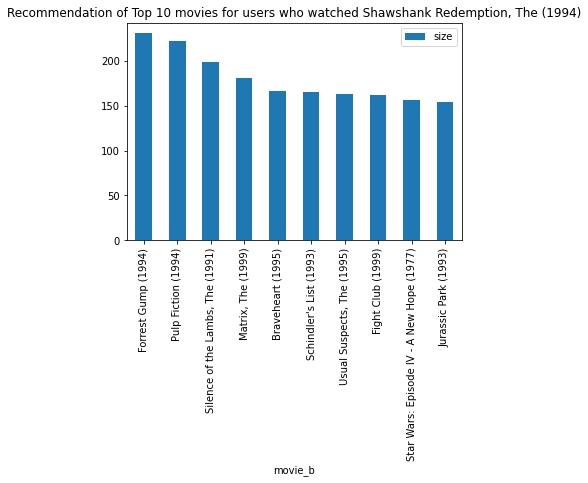

In [17]:
from itertools import permutations

def create_pairs(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),\
                       columns=["movie_a", "movie_b"])
  return pairs

movie_pairs = movie_df.groupby("userId")["title"].apply(create_pairs)
movie_pairs = movie_pairs.reset_index(drop=True)
pair_counts = movie_pairs.groupby(by=["movie_a", "movie_b"]).size()
pair_counts_df = pair_counts.to_frame(name="size").reset_index()
pair_counts_sorted = pair_counts_df.sort_values("size", ascending=False)
shawshank_df =  pair_counts_sorted[pair_counts_sorted["movie_a"]=="Shawshank Redemption, The (1994)"]

shawshank_df[:10].plot.bar(x="movie_b")
plt.title("Recommendation of Top 10 movies for users who watched Shawshank Redemption, The (1994)")
plt.show()

## 2. 컨텐츠 기반 추천 (Item, Content-based Recommendations)
---
1. Item의 속성 및 특성 (Attributes or characteristics)를 추출한다
  - 예시: 책 (언어, 장르, 저자, 출판일자, 페이지 수, ...)
2. Item 끼리의 유사도를 계산
  - Item X와 Y의 유사도가 높다
2. 사용자 A가 Item X를 좋아한다
3. 사용자 A에게 Item Y를 추천한다

### 2.1 Item (영화)의 특성 추출
Item attributes: 영화의 장르

In [136]:
# 영화 제목과 장르
movie_genre_df = movies_original.copy()
movie_genre_df["genres"] = movie_genre_df['genres'].str.split("|")
movie_genre_df = movie_genre_df.explode(["genres"])[["title", "genres"]].reset_index(drop=True)
movie_genre_df = movie_genre_df[movie_genre_df["genres"]!="(no genres listed)"]

# Crosstabulation
genres_array_df = pd.crosstab(movie_genre_df["title"], movie_genre_df["genres"])
display(genres_array_df.head())

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,
'71 (2014),1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
'Hellboy': The Seeds of Creation (2004),1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
'Round Midnight (1986),0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
'Salem's Lot (2004),0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
'Til There Was You (1997),0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


### 2.2 Item간의 유사도 계산
Jaccard Similarity $J(A, B)=\frac{A\cap B}{A\cup B}$

In [137]:
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
toystory_row = genres_array_df.loc['Toy Story (1995)']
jumanji_row = genres_array_df.loc['Jumanji (1995)']

# 토이 스토리와 쥬만지의 자카드 유사도 = 0.6 (높다, 장르가 유사하다)
print(jaccard_score(toystory_row, jumanji_row))

jaccard_distances = pdist(genres_array_df.values, metric='jaccard')
square_jaccard_distances = squareform(jaccard_distances)

# 자카드 유사도 행렬
jaccard_similarity_array = 1-square_jaccard_distances
print(jaccard_similarity_array[:5, :5])

0.6
[[1.         0.125      0.2        0.33333333 0.2       ]
 [0.125      1.         0.         0.         0.        ]
 [0.2        0.         1.         0.2        0.33333333]
 [0.33333333 0.         0.2        1.         0.2       ]
 [0.2        0.         0.33333333 0.2        1.        ]]


In [20]:
similarity_df = pd.DataFrame(
    jaccard_similarity_array,
    index = genres_array_df.index,
    columns = genres_array_df.index)
# display(similarity_df.head())

# 토이 스토리와 유사도가 높은 상위 10개의 영화 (자기 자신은 제외하자)
print(similarity_df["Toy Story (1995)"].sort_values(ascending=False)[:10])

title
Emperor's New Groove, The (2000)                  1.0
Adventures of Rocky and Bullwinkle, The (2000)    1.0
Antz (1998)                                       1.0
Toy Story 2 (1999)                                1.0
Toy Story (1995)                                  1.0
Shrek the Third (2007)                            1.0
Moana (2016)                                      1.0
Wild, The (2006)                                  1.0
The Good Dinosaur (2015)                          1.0
Monsters, Inc. (2001)                             1.0
Name: Toy Story (1995), dtype: float64


### 2.3 텍스트 기반 유사도
TF-IDF (Term Frequency Inverse Document Frequency)

$\text{TF-IDF}=\frac{\frac{\text{count of word occurrences}}{\text{Total words in document}}}{\log \frac{\text{Number of docs word is in}}{\text{Total number of docs}}}$

데이터 불러오기

In [21]:
book_summary_df = pd.read_csv("plots.csv", sep=",")
book_summary_df.head()

,Book,Description
0,Ace Ventura: When Nature Calls,"In the Himalayas, after a failed rescue missio..."
1,Dracula: Dead and Loving It,Solicitor Thomas Renfield travels all the way ...
2,Father of the Bride Part II,"""The film begins five years after the events o..."
3,Four Rooms,"The film is set on New Year\'s Eve, and starts..."
4,Grumpier Old Men,The feud between Max (Walter Matthau) and John...


책 요약 줄거리를 가지고 TF-IDF 방식으로 각 책의 특성을 벡터화 하기

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer(min_df=2, max_df=.7)
vectorized_data = tfidfvec.fit_transform(book_summary_df['Description'])
print(tfidfvec.get_feature_names())
# print(vectorized_data.toarray())

tfidf_df = pd.DataFrame(
    vectorized_data.toarray(),
    columns=tfidfvec.get_feature_names()
)
tfidf_df.index = book_summary_df['Book']
print(tfidf_df.head())

Cosine similarity $\cos \theta = \frac{A\cdot B}{\vert\vert A\vert\vert \cdot \vert\vert B\vert\vert}$

책마다 단어들을 기반으로 특성을 벡터화했으면, 두 벡터의 코사인 유사도를 계산하여 책 간의 유사도 계산

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_array = cosine_similarity(tfidf_df)
cosine_similarity(
    tfidf_df.loc['Four Rooms'].values.reshape(1, -1),
    tfidf_df.loc['Grumpier Old Men'].values.reshape(1, -1)
)

array([[0.21411564]])

### 사용자 프로파일 기반 추천

Item to item recommendation
1. 사용자가 읽은 책 리스트를 추출한다.
2. 책 리스트의 특성들을 기반으로 사용자의 프로파일을 생성한다.
3. 사용자의 프로파일과 유사도가 높은 책들을 추천한다


In [24]:
# 사용자 A가 읽은 책
list_of_books_read = ["Four Rooms", "Grumpier Old Men"]
user_books = tfidf_df.reindex(list_of_books_read)

# 사용자 A의 프로파일: 책의 특성들의 평균
user_prof = user_books.mean()
# 사용자 A가 읽은 책 제외
non_user_books = tfidf_df.drop(list_of_books_read, axis = 0)
# 사용자의 프로파일과 나머지 책들 간의 코사인 유사도 계산
user_prof_similarity = cosine_similarity(user_prof.values.reshape(1, -1), non_user_books)

user_prof_similarity_df = pd.DataFrame(
    user_prof_similarity.T,
    index = non_user_books.index,
    columns = ["cosine_similarity_score"]
).sort_values("cosine_similarity_score", ascending=False)
user_prof_similarity_df.head()

,cosine_similarity_score
Book,
Father of the Bride Part II,0.257056
Toy Story,0.255008
Dracula: Dead and Loving It,0.229904
Jumanji,0.214510
Tom and Huck,0.209247


## 3. Collaborative Filtering
---
사용자 간의 유사성을 활용한다
- 사용자 A, B, C는 책 X를 좋아한다
- 사용자 B, C는 책 Y를 좋아한다

$\therefore$ 사용자 A에게는 (책 Y를 읽지 않았으므로) 책 Y를 추천해줄 수 있다

1. 피벗 테이블을 생성한다.
- 행은 userId
- 열은 영화
- 값은 평점

2. 사용자마다 NaN이 아닌 값으로 평균 평점을 만들고
그 평균 값을 평점에서 뺀다
- Zero-Centered values



In [147]:
user_ratings = user_ratings.drop_duplicates(["userId", "title"])
user_ratings_pivot = user_ratings.pivot(
    index = "userId",
    columns = "title",
    values = "rating"
)

avg_ratings = user_ratings_pivot.mean(axis=1)
user_ratings_pivot_centered = user_ratings_pivot.sub(avg_ratings, axis=0).fillna(0)

movie_ratings_pivot = user_ratings_pivot.T
movie_ratings_pivot_centered = user_ratings_pivot_centered.T

### 3.1 User-based와 Item-based
- User-based는 (사용자, 아이템)의 행렬
- Item-based는 (아이템, 사용자)의 행렬

Item-item similarity
- 영화 간의 Cosine similarity
- Toy Story (1995)와 유사도가 높은 영화 찾기

In [148]:
similarities = cosine_similarity(movie_ratings_pivot_centered)
similarities_df = pd.DataFrame(
    similarities,
    index = movie_ratings_pivot.index,
    columns = movie_ratings_pivot.index
)

cosine_similarity_series = similarities_df.loc['Toy Story (1995)']
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
# print(ordered_similarities)

title
Toy Story (1995)                               1.000000
Toy Story 2 (1999)                             0.403420
Toy Story 3 (2010)                             0.327485
Aladdin (1992)                                 0.327245
Wallace & Gromit: The Wrong Trousers (1993)    0.305483
                                                 ...   
Honey, I Blew Up the Kid (1992)               -0.222452
Batman & Robin (1997)                         -0.223622
Around the World in 80 Days (2004)            -0.229409
Mixed Nuts (1994)                             -0.233548
Flintstones in Viva Rock Vegas, The (2000)    -0.285490
Name: Toy Story (1995), Length: 9719, dtype: float64


User-user similarity
- 사용자 A (userId = 1)과 가장 유사하게 평점을 준 사용자들을 나열
- Top 3명을 골라서, 그들이 Aladdin (1992) 영화에 부여한 평점 보기

In [149]:
similarities = cosine_similarity(user_ratings_pivot_centered)
similarities_df = pd.DataFrame(
    similarities,
    index = user_ratings_pivot.index,
    columns = user_ratings_pivot.index
)

cosine_similarity_series = similarities_df.loc[1]
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
nearest_neighbors = ordered_similarities[1:4].index
print(nearest_neighbors)

neighbor_ratings = user_ratings_pivot.reindex(nearest_neighbors)
neighbor_ratings['Aladdin (1992)'].mean()

Int64Index([301, 597, 414], dtype='int64', name='userId')


4.0

### 3.2 K-Nearest Neighborhood (KNN)
사용자 A와 유사한 K명을 고르기

In [150]:
user_ratings_table = user_ratings_pivot
user_ratings_pivot = user_ratings_pivot_centered

In [151]:
user_ratings_pivot.drop("Aladdin (1992)", axis=1, inplace=True)
# userId 1의 평점 (Aladdin 제외) 
target_user_x = user_ratings_pivot.loc[[1]]
# print(target_user_x)

In [ ]:
# Aladdin에 영화에 대한 각 사용자들의 평점
other_users_y = user_ratings_table["Aladdin (1992)"]

# Aladdin을 본 사람들의 영화 정규화 평점
other_users_x = user_ratings_pivot[other_users_y.notnull()]
# print(other_users_x)

other_users_y.dropna(inplace=True)
# print(other_users_y)

In [153]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=3)
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
print(user_user_pred)

[3.66666667]


In [154]:
## 평점 y는 .5 단위인데, KNN에서 y (label)는 정수여야 해서 값을 변환한다.
unique_values_y = sorted(list(set(other_users_y)))
dict_encode = {item: i for i, item in enumerate(unique_values_y)}
dict_decode = {i: item for i, item in enumerate(unique_values_y)}

other_users_y = np.array([dict_encode[item] for item in other_users_y])

In [156]:
# other_users_x = other_users_x.to_numpy()
# other_users_y = other_users_y.to_numpy()

from sklearn.neighbors import KNeighborsClassifier
user_knn = KNeighborsClassifier(metric='cosine', n_neighbors=3)
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
# print(user_user_pred)
print("Predicted score of Aladdin: ", dict_decode[user_user_pred[0]])

Predicted score of Aladdin:  4.0


### 3.3 Summary
Recommendation의 목적은 결국 "특정 사용자"가 "가장 좋아할만한 Item"을 제안하는 것
- Item-based
  - Item 간의 유사도를 미리 계산해두고
  - 사용자가 선택한 Item list의 특성에 따라서 다른 Item에 대한 사용자의 선호도를 계산
- User-based
  - 사용자들 간의 유사도를 계산하고 
  - 특정 사용자와 가장 비슷한 사용자들이 선호하는 제품들 중에서 선택

||Pros|Cons|
|---|---|---|
|Item-based|시간이 지나도 일관성이 있는 결과, 설명하기 쉬움, 미리 계산할 수 있음|결과가 너무 명백하다|
|User-based|다른 사용자들의 성향에 따라 흥미로운 결과 도출이 가능하다|-|

## 4. Matrix Factorization
---
Data sparsity $s = \frac{\text{Empty values}}{\text{Total cells}}$

Sparsity를 고려해야 하는 이유
- $s$가 크다는 것은 사용자 데이터가 많이 없다는 것을 의미
- 이러한 경우 KNN 방식을 쓰기에는 n_neighbor개 만큼의 데이터가 없을 확률이 높으므로 유의미한 결과를 얻기 어렵다.

In [104]:
user_ratings = user_ratings.drop_duplicates(["userId", "title"])
user_ratings_pivot = user_ratings.pivot(
    index = "userId",
    columns = "title",
    values = "rating"
)
movie_ratings_df = user_ratings_pivot.copy()

number_of_empty = movie_ratings_df.isnull().values.sum()
total_number = movie_ratings_df.size

sparsity = number_of_empty / total_number
print(sparsity)
print(movie_ratings_df.notnull().sum())

0.9829922460483859
title
'71 (2014)                                    1
'Hellboy': The Seeds of Creation (2004)       1
'Round Midnight (1986)                        2
'Salem's Lot (2004)                           1
'Til There Was You (1997)                     2
                                             ..
eXistenZ (1999)                              22
xXx (2002)                                   24
xXx: State of the Union (2005)                5
¡Three Amigos! (1986)                        26
À nous la liberté (Freedom for Us) (1931)     1
Length: 9719, dtype: int64


### 4.1 SVD (Singular Value Decomposition)

In [ ]:
avg_ratings = movie_ratings_df.mean(axis=1)
movie_ratings_pivot_centered = movie_ratings_df.sub(
    avg_ratings, axis=0
)
movie_ratings_pivot_centered.fillna(0, inplace=True)
movie_ratings_pivot_centered

In [71]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(movie_ratings_pivot_centered)

In [72]:
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings += avg_ratings.values.reshape(-1, 1)
recalculated_ratings = pd.DataFrame(
    recalculated_ratings,
    index = movie_ratings_df.index,
    columns = movie_ratings_df.columns
)

### 4.2 Validating predicted results

Hold-out sets

In [ ]:
x, y = 60, 100
movie_ratings_df_copy = movie_ratings_df.copy()

actual_values = movie_ratings_df_copy.iloc[-x:, -y:].values.copy()

movie_ratings_df_copy.iloc[-x:, -y:] = np.nan

predicted_values = recalculated_ratings.iloc[:x, :y].values.copy()
mask = ~np.isnan(actual_values)
# print(actual_values[mask])
# print(predicted_values[mask])

In [128]:
from sklearn.metrics import mean_squared_error

print(
    mean_squared_error(
        actual_values[mask],
        predicted_values[mask],
        squared=False
    )
)

1.251051392368875
